# Titanic Project 

OTitanic foi um navio de passageiros britânico que afundou no Oceano Atlântico Norte em 1912 após colidir com um iceberg em sua primeira viagem em que estava indo de Southampton para Nova York.
Estima-se que estavam a bordo 2.224 pessoas dentre passageiros e tripulantes do navio. Estima-se que mais de 1.500 morreram o que tornou o Titanic um dos principais (se não o principal) desastre marítimo em todos estes anos.
Dito isso, a problemática aqui é criar um modelo preditivo que possa prever qual passageiro iria sobreviver ou morrer no desastre.

Pontos importantes antes de iniciarmos:
-Como nosso evento de interesse é categórico (viver ou morrer), nosso modelo será um modelo de classificação, em que o target (ou a variável resposta) é viver ou morrer.
-Como faremos processos em diversas variáveis iremos criar funções para gerar os outputs assim reduziremos e deixaremos o código mais "clean" e fácil de interpretação.
Então, bora lá!


O que veremos aqui:

1) Conhecendo a base

2) Análise descritiva

3) Seleção das variáveis

4) Processamento dos dados

5) Rodando os modelos

6) Conclusão

7) Submissão no Kaggle

In [1]:
# importando os pacotes necessários
import pandas as pd #formatação de bases
import numpy as np #utilizo em loops e funções para alocação dos resultados/variáveis
from xgboost import XGBClassifier #modelo escolhido 1
from sklearn.linear_model import LogisticRegression #modelo escolhido 2
from sklearn.ensemble import RandomForestClassifier #modelo escolhido 3
from sklearn.model_selection import cross_val_score #cross validation
import warnings
warnings.filterwarnings("ignore") #ignorando warnings dos modelos

#### 1) Conhecendo a base

Iniciaremos conhecendo a nossa base, verificando quais são os atributos contidos nela, quais são os tipos dos atributos e investigar possíveis falhas e mudanças necessárias na base de dados.

O Kaggle fornece os dados para o desafio TITANIC já separados em treino em teste, porém considero de extrema importância compreender a base de dados em sua totalidade antes de dividir, então irei concatenar e utilizar a amostra para exploração e quando chegarmos ao Machine Learning usar as bases divididas.

##### Lendo e concatenando a base

In [2]:
test = pd.read_csv('../input/titanic/test.csv') # csv de teste
train = pd.read_csv('../input/titanic/train.csv') # csv de treino
all_data = train.append(test, ignore_index=True) # juntando a base
all_data.columns #nomes de colunas

#test = test.dropna() #retirando NA's desde o inicio pois posso esquecer esse processo e ter problemas no futuro
#train = train.dropna() #retirando NA's desde o inicio pois posso esquecer esse processo e ter problemas no futuro



Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

##### Descrição das variáveis:

* PassengerId: Identificação de cada passageiro
* Survived: O passageiro sobreviveu ou não? (1 = Sobreviveu / 0 = Morreu)
* Pclass: A classe de viagem do passageiro (Primeira Classe, Segunda Classe....)
* Name: Nome do Passageiro
* Sex: Gênero do Passageiro
* Age: Idade do Passageiro
* SibSp: Número de Irmãos ou Cônjuges abordo
* Parch: Número de Pais ou Crianças aborod
* Ticket: Número de ticket do passageiro
* Fare: Valor de tarifa paga
* Cabin: Número da cabine do Passageiro
* Embarked: Porto de Embarcação (C = Cherbourg / Q = Queenstown / S = Southampton)

##### Tipo das variáveis

In [3]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


A maioria dos valores são categóricos o que faz sentido visto que são características referentes aos passageiros.
Temos informações sobre 1309 passageiros do navio.

##### Identificando valores nulos e/ou duplicados

In [4]:
# Quantidade de valores nulos serão os de teste pois a base não tem o survived
  #quantitade de valores nulos na base total
print('Quantidade de valores nulos na base de dados:', all_data.isna().sum().sum()) 

# nulos em cada base treino
print('Quantidade de valores nulos na base de treino:', train.isna().sum()) # são os valores da base de teste

# nulos em cada base teste
print('Quantidade de valores nulos na base de teste:', test.isna().sum()) # são os valores da base de teste

# Removendo valores duplicados
all_data=all_data.drop_duplicates()
print('Dimensão após excluir linhas duplicadas:', all_data.shape)



Quantidade de valores nulos na base de dados: 1698
Quantidade de valores nulos na base de treino: PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Quantidade de valores nulos na base de teste: PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
Dimensão após excluir linhas duplicadas: (1309, 12)


##### Sumário estatístico dos dados

In [5]:
all_data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,1309.000000,891.000000,1309.000000,1309,1309,1046.000000,1309.000000,1309.000000,1309,1308.000000,295,1307
unique,NaN,NaN,NaN,1307,2,NaN,NaN,NaN,929,NaN,186,3
top,NaN,NaN,NaN,"Connolly, Miss. Kate",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,2,843,NaN,NaN,NaN,11,NaN,6,914
mean,655.000000,0.383838,2.294882,NaN,NaN,29.881138,0.498854,0.385027,NaN,33.295479,NaN,NaN
std,378.020061,0.486592,0.837836,NaN,NaN,14.413493,1.041658,0.865560,NaN,51.758668,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,328.000000,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,655.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,982.000000,1.000000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN


O sumário descritivo é de alta relevância no inicio da análise pois podemos ver as estatísticas mais rápidas e já entender as informações em que estamos lidando.
Com este quadro podemos prceber que os passageiros tinham média de idade de 29 anos, evidenciando uma tripulação e passageiros jovens com tarifa média de 32.
Por serem em sua maioria categóricas este sumário estatístico se torna limitado às numéricas.


### 2) Análise Exploratória 

Agora analisaremos visualmente os dados e para isso iremos começar com distribuição de frequencia absoluta (contagem) das variáveis qualitativas.

Após este processo iremos analisar as quantitativas e por fim (antes de passar à próxima seção)  daremos enfoque na relação entre as variáveis e a target, investigando associações e informações que possam ser de importância.

##### Variáveis Qualitativas

In [6]:
# escrevendo a função para gerar os gráficos de barra
def Plot_Bar(dados, colunas):
    
    import matplotlib.pyplot as plt
    
    %matplotlib inline
    
    
    fig, subPlot=plt.subplots(nrows=1, ncols=len(colunas), figsize=(19,5))
    fig.suptitle('Bar charts of: '+ str(colunas))

    for nomecoluna, ngraficos in zip(colunas, range(len(colunas))):
        dados.groupby(nomecoluna).size().plot(kind='bar',ax=subPlot[ngraficos])
        

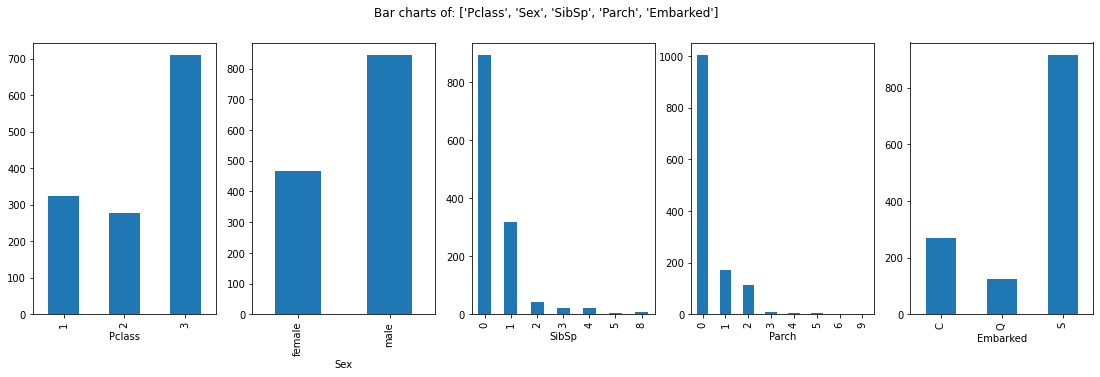

In [7]:
# chamando a função
Plot_Bar(dados=all_data, colunas=['Pclass', 'Sex', 'SibSp','Parch','Embarked'])

Gráficos de barra são a melhor opção quando desejamos retirar insights rápidos de distribuição de variáveis. De cara algumas pontuações podem ser feitas a partir das visualizações: A maioria dos passageiros eram do sexo masculino e viajaram na terceira classe, a maioria dos passageiros não tinham parentes/filhos/cônjuges no navio e a grande maioria embarcou em Southampton.


##### Variáveis Quantitativas

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

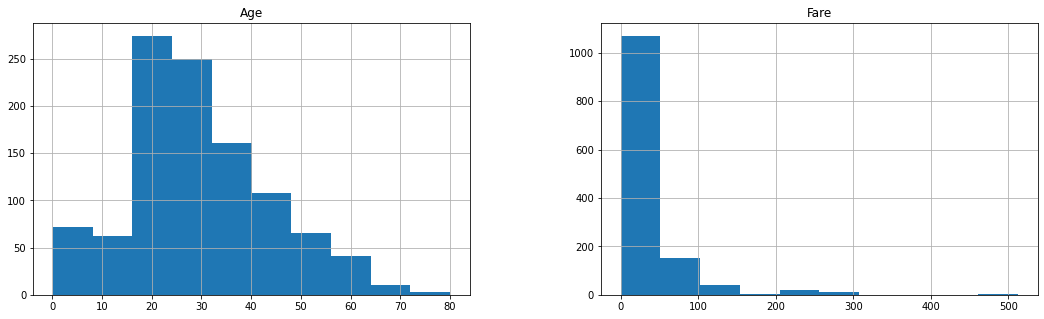

In [8]:
# histograma nas quantitativas
all_data.hist(['Age', 'Fare'], figsize=(18,5))

A distribuição de idade dos passageiros evidencia que a maioria estava entre 18 à 40 anos.
Já sobre a tarifa paga vemos que a maioria dos passageiros pagou de 0 à 100, concentrado em 50.

#### Análise das variáveis com a target 


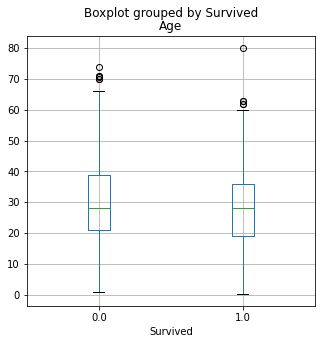

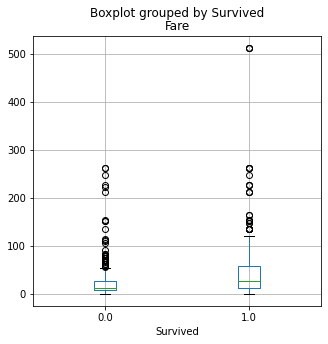

In [9]:
# Box plots entre a target e s variáveis contínuas (vai identificar a dispersão em torno da variável)
variaveis_continuas=['Age','Fare']

import matplotlib.pyplot as plt


# Creating box plots for each continuous predictor against the Target Variable "Survived"
for target , i in zip(variaveis_continuas, range(len(variaveis_continuas))):
    all_data.boxplot(column=target, by='Survived', figsize=(5,5), vert=True)

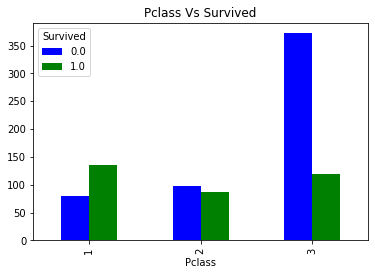

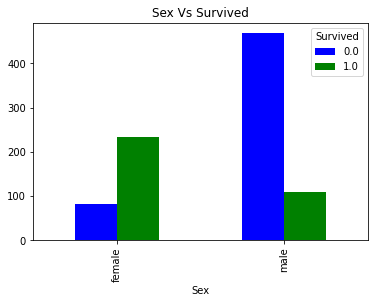

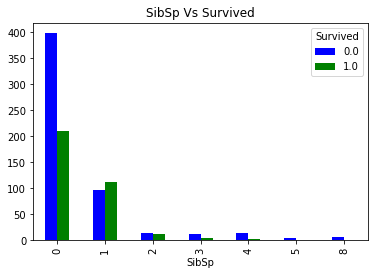

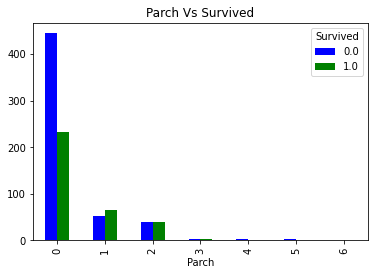

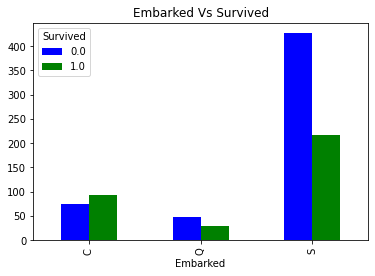

In [10]:
# gráficos de colunas entre as categóricas e a taret
colunas_categoricas=['Pclass', 'Sex', 'SibSp','Parch','Embarked']

for CategoricalCol , i in zip(colunas_categoricas, range(len(colunas_categoricas))):
    table=pd.crosstab(index=all_data[CategoricalCol], columns=all_data['Survived'])
    table.plot.bar(color=['blue','green'], title=CategoricalCol+' Vs '+'Survived')

In [11]:
# Outra visão entre a variável "Sexo" e a target (em porcentagem)
table=pd.crosstab(index=all_data['Sex'], columns=all_data['Survived'], normalize=True)
table

Survived,0.0,1.0
Sex,,
female,0.090909,0.261504
male,0.525253,0.122334


Os box plot da variável target com a idade mostrou que dos passageiros que sobreviveram aos que morreram existe uma leve diferença de idade, para os que sobreviveram o intervalo de confiança é maior então, o que sugere que pessoas mais velhas sobreviveram ao desastre ao contrário do falecimento que tem um intervalo de confiança menor, no mais, os box plot indicaram que as informações de passageiros estão bem distribuídas independete do evento sem grandes dispersões ou muitos outliers (conseguimos identificar claramente um outlier) o que para uma base que será utilizada em modelos é bem importante. O mesmo (e talvez mais forte) é observado para a variável de pagamento da tarifa, o que faz sentido pois a tarifa não deveria ser tão dispersa entre os passageiros.
Nadistribuição da variável target no sexo foi possível observar que do evento de sobreviver a maioria foi do sexo masculino (52%), e do evento de falecimento a maioria foi do sexo feminino.
A maioria dos sobreviventes eram da terceira classe, essa relação pode ser explicada foi a quantidade de passageiros na terceira classe também foi maior, é natural que esta classe esteja destacada no gráfico.
Outro ponto importante que foi de possível percepção foi que os passageiros que embarcaram em Southampton sobreviveram mais que os outros, essa relação também pode ser uma relação implícita de quantidade mas também pode sugerir que este era o porto mais próximo. 


### 3) Seleção das variáveis para o modelo

A seleção de variáveis se dará por meio de testes estatísticos que checam correlação entre duas variáveis em dois processos diferentes.
Para variáveis categoricas utilizaremos teste do qui-quadrado
Para variáveis contínuas utilizaremos o teste de ANOVA (Analise das variâncias)

Tanto a ANOVA quanto o qui-quadrado são testes utilizados para evidenciar se as variáveis são estatísticamente significativas, estas diferem apenas em utilização (uma pra variáveis categóricas e outra numéricas) e em distribuição.


Tanto para o teste de ANOVA quanto o do qui-quadrado as Hipoteses são:

**H0:** As colunas NÃO são relacionadas. Não é estatisticamente significativo

**H1:** As colunas SÃO são relacionadas. É estatisticamente significativo

###### Variáveis Categóricas

In [12]:
# Esrevendo a função do qui-quadrado
def qui_quadradofunc(dados, target, variaveis_categoricas):
    from scipy.stats import chi2_contingency
    
    # Lista vazia para alocar as variáveis selecionadas
    variaveis_selecionadas=[]
    
    #loop para aplicar o teste as variáveis
    for i in variaveis_categoricas:
        table_cross=pd.crosstab(index=dados[target], columns=dados[i])
        chi_result = chi2_contingency(table_cross)
        
        # Se o p_valor do qui-quadrado for menor que  <0.05, rejeitamos H0 e é estatisticamente significativo
        if (chi_result[1] < 0.05):
            print(i, 'is correlated with', target, '| P-Value:', chi_result[1])
            variaveis_selecionadas.append(i)
        else:
            print(i, 'is NOT correlated with', target, '| P-Value:', chi_result[1])        
            
    return(variaveis_selecionadas)


In [13]:
categoricas=['Pclass', 'Sex', 'SibSp','Parch','Embarked']

# Usando a função 
qui_quadradofunc(dados=all_data, 
              target='Survived',
              variaveis_categoricas= categoricas)

Pclass is correlated with Survived | P-Value: 4.549251711298793e-23
Sex is correlated with Survived | P-Value: 1.1973570627755645e-58
SibSp is correlated with Survived | P-Value: 1.5585810465902116e-06
Parch is correlated with Survived | P-Value: 9.703526421039997e-05
Embarked is correlated with Survived | P-Value: 1.769922284120912e-06


['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

###### Variáveis Contínuas

In [14]:
# Função para gerar o teste de ANOVA
def anovafunc(dados, target, variaveis_continuas):
    from scipy.stats import f_oneway

    # criando a lista com as variáveis selecionadas
    variaveis_selecionadas=[]
    
    #loop para aplicar o teste as variáveis
    for i in variaveis_continuas:
        continua_group=dados.groupby(target)[i].apply(list)
        anova_result = f_oneway(*continua_group)
                
        # Printar o resultado, se p-valor menor que 0.05 rejeitar H0 e variáveis são correlacionadas
        if (anova_result[1] < 0.05):
            print(i, 'tem associação estatisticamente significativa com ', target, '| P-Value:', anova_result[1])
            variaveis_selecionadas.append(i)
        else:
            print(i, ' NÃO tem associação estatisticamente significativa com ', target, '| P-Value:', anova_result[1])
    
    return(variaveis_selecionadas)


In [15]:
# Usando a função 
variaveiscontinuas=['Age','Fare']
anovafunc(dados=all_data, target='Survived', variaveis_continuas=variaveiscontinuas)

Age  NÃO tem associação estatisticamente significativa com  Survived | P-Value: nan
Fare tem associação estatisticamente significativa com  Survived | P-Value: 6.120189341921873e-15


['Fare']

A partir do resultados dos testes descobrimos que as variáveis com associação significativa e que irão continuar no processo são: 
1. Classe da viagem do Passageiro
2. Gênero
3. Número de Irmãos ou Cônjuges abordo
4. Número de Pais ou Crianças abordo
5. Valor de tarifa paga
6. Porto de Embarcação


In [16]:
colunas_selecionadas=['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked','Fare']

# Selecting final columns
selec_train = train[colunas_selecionadas]
test = test[colunas_selecionadas]

### 4) Processamento dos dados 

Antes de entramos na etapa de machine Learning algumas transformações são necessárias para garatir que o desempenho do modelo não seja afetado por algum tipo de erro:
- Tratar Nan valores
- Transformar variáveis binárias em numéricas (1/0) (Sobreviventes)
- Gerar dummies nas variáveis nominais categóricas

Além disso voltaremos a utilizar a base de treino e teste nesta seção.



In [17]:
#Fare
selec_train['Fare'] = np.where(selec_train.Fare.isna(), np.mean(test.Fare), selec_train.Fare)
test['Fare'] = np.where(test.Fare.isna(), np.mean(test.Fare), test.Fare)


In [18]:
#Fare
selec_train['Embarked'] = np.where(selec_train.Embarked.isna(), 'Unknow', selec_train.Embarked)
test['Embarked'] = np.where(test.Embarked.isna(), 'Unknow', test.Embarked)

In [19]:
# nulos em cada base treino
print('Quantidade de valores nulos na base de treino:', selec_train.isna().sum()) # são os valores da base de teste

# nulos em cada base teste
print('Quantidade de valores nulos na base de teste:', test.isna().sum()) # são os valores da base de teste


Quantidade de valores nulos na base de treino: Pclass      0
Sex         0
SibSp       0
Parch       0
Embarked    0
Fare        0
dtype: int64
Quantidade de valores nulos na base de teste: Pclass      0
Sex         0
SibSp       0
Parch       0
Embarked    0
Fare        0
dtype: int64


In [20]:
# Converter variável categoria sexo em  binária
selec_train['Sex'].replace({'female':0, 'male':1}, inplace=True)
test['Sex'].replace({'female':0, 'male':1}, inplace=True)

In [21]:
# Converter as outras variáveis nominais em dummie¶
selec_train=pd.get_dummies(selec_train)
test=pd.get_dummies(test)


# Adicionando a variável target de volta para a base
selec_train['Survived']=train['Survived']

# Printando head do treino
selec_train.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Embarked_Unknow,Survived
0,3,1,1,0,7.2500,0,0,1,0,0
1,1,0,1,0,71.2833,1,0,0,0,1
2,3,0,0,0,7.9250,0,0,1,0,1
3,1,0,1,0,53.1000,0,0,1,0,1
4,3,1,0,0,8.0500,0,0,1,0,0


##### Definindo o X_train, y_train e X_train que será ultilizado nos modelos:

In [22]:
target='Survived'
variaveis=['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q','Embarked_S']

X_train = selec_train[variaveis]
y_train = selec_train[target]
X_test = test


### 5) Rodando modelos

Para os modelos optei por três dos principais modelos utilizados em problemas de classificação:
* XGBoost
* RandomForest
* Logistic Regression

###### *Não utilizei nenhum tipo de Normalização nos dados pois com estes modelos não é necessário/obrigatório e não afeta tanto o desempenho e performance

#### **XGBoost**

A denominação "XGBoost" vem de eXtreme Gradient Boosting e representa uma categoria de algoritmos baseados em Decision Trees (árvores de decisão) com Gradient Boosting (aumento de gradiente), essa junção do aumento de gradiente e as árvores de decisão contribuem para que a cada novo modelo a ser implementado a perca (loss) seja menor.
É um algoritmo recente e que vem ganhando espaço nas competições do Kaggle, principalmente pela facilidade em ajustar paramêtros (o que não faremos hoje). 

In [23]:
# Definindo o modelo e parametros (testei alguns para chegar no "ideal")
clf=XGBClassifier(max_depth=8, learning_rate=0.1,
                  n_estimators=280, objective='binary:logistic', booster='gbtree')


# Criando o modelo na base de treino
XGB=clf.fit(X_train,y_train)

# predição
prediction=XGB.predict(X_test)

# Rodando o cross validation e gerando a acurácia do modelo
acuracia_values=cross_val_score(XGB, X_train , y_train, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',acuracia_values)
print('\nFinal Average Accuracy of the model:', acuracia_values.mean())



[17:36:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:36:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:36:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:36:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

#### **Floresta aleatória**

Florestas aleatórias ou florestas de decisão aleatória (em inglês RandomForest) correspondem à um método de Machine Learning para bases de classificação, regressão e outras tarefas que operam assim como o nome diz, construindo uma infinidade de ávores de probabilidade e decisão até que seja ou atingido o objetivo ou parado através dos paramêtros.

In [24]:
# Definindo parametros max_depth/n_estimator / criterion (testei alguns e cheguei no "ideal")
clf = RandomForestClassifier(max_depth=4, n_estimators=300,criterion='gini')

# Creating the model on Training Data
RF=clf.fit(X_train,y_train)

# predição
prediction=RF.predict(X_test)

# Rodando o cross validation e gerando a acurácia do modelo
acuracia_values=cross_val_score(RF, X_train , y_train, cv=10, scoring='f1_weighted')
print('\nAccuracy values for 10-fold Cross Validation:\n',acuracia_values)
print('\nFinal Average Accuracy of the model:', acuracia_values.mean())




Accuracy values for 10-fold Cross Validation:
 [0.77097382 0.73447598 0.77256866 0.86332052 0.88610043 0.81433378
 0.80164322 0.73163495 0.82285899 0.80001088]

Final Average Accuracy of the model: 0.7997921227543363


#### **Regressão Logística**
Regressão Logística são modelos estatísticos que usam o básico da Regressão Logística (que é uma função com a variável dependente sendo binária), para que seja melhorada essa regressão sçao utilizados parâmetros.


In [25]:
# Definindo os parametros C / penalty / solver (testei alguns até chegar no "ideal")
clf = LogisticRegression(C=5,penalty='l2', solver='newton-cg')

# Criando o modelo e treinando os dados
LOG=clf.fit(X_train,y_train)

# predição
prediction=LOG.predict(X_test)


# Rodando o cross validation e gerando a acurácia do modelo
acuracia_values=cross_val_score(LOG, X_train , y_train, cv=10, scoring='f1_weighted')
print('\nAcurácia em k=10 cross validation:\n',acuracia_values)
print('\nAcurácia Final:', acuracia_values.mean())


Acurácia em k=10 cross validation:
 [0.77649393 0.77641044 0.77021909 0.82182649 0.7987694  0.75981111
 0.78268624 0.75756502 0.79649424 0.78302904]

Acurácia Final: 0.7823304996937719


### 6) Conclusão
Conclusões sobre a competição e a escolha do modelo

Foi possível obter aproximadamente 80% de acurácia com o modelo XGBoost e que me fez escolher por ele.

Considero um grande feito para um modelo desenvolvido do zero em menos de dois dias e com grande simplicidade, aceito como um bom resultado mas que pode ser muito melhorado. 
Pontos de melhora já identificados:
- Testar Hiperparametrização até achar o ideal (fiz na tentativa e erro devido ao tempo)
- Fazer Normalização nas variáveis para testar com e sem


### 7) Submissão no Kaggle
Agora é hora de submeter os resulados ao Kaggle! Foi ótima esta mini-jornada, muito obrigada!

In [26]:
#Gerar a base de teste e predições e submeter ao kaggle
output_df = pd.read_csv('../input/titanic/test.csv')
output = output_df.loc[X_test.index]
prediction=XGB.predict(X_test) # com o melhor algoritmo
output['Survived'] = prediction
output = output[['PassengerId', 'Survived']]
output.to_csv('submission.csv', index=False)